# Integrating dataset with Scalex

In [5]:
import scalex
from scalex import SCALEX, label_transfer
from scalex.plot import embedding
import scanpy as sc
import pandas as pd
import numpy as np # needs to be verion 1.23.3 to be compatible with scalex
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import glob
import re

In [2]:
# checking python version
import sys
print(sys.version)

3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]


In [3]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)
sc.logging.print_header()
plt.rcParams['axes.unicode_minus']=False

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.23.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [4]:
sns.__version__

'0.13.2'

In [5]:
scalex.__version__

'1.0.2'

In [1]:
def my_Anndata(main_folder_name):
    '''
    Create a dictionnary of an Anndata object from three different files. the key is the name of the sample and the value is the Anndat object
    
    Input: str, name of the main folder where the sub_folder containing the files of interest are located
    
    output: dictionnary with all Anndata objects    
    '''
    adata_dict = {}
    # Reading the 12 folders names
    directories_names = glob.glob(f"{main_folder_name}"+f"/*[0-9]")
    # Then loop over each folder
    for directories  in directories_names:
        
        # Then sparse the files within the folder
        files_names = glob.glob(f"{directories}/*")
        for file in files_names:
            
            # Getting the files in the directory that correspond to the matrix
            if re.match(".*(matrix.mtx)", file):
                
                # create the Anndata object
                adata = sc.read_mtx(file, dtype='float32')
                adata = adata.T.copy() # Without copy - downstream does not work correctly 
    
           
            # Getting the file with the features
            if re.match(".*((genes)|(features))(.tsv)", file):
                
                # store this file as the var attribute of the Anndata object
                genes_df = pd.read_csv (file, sep = '\t', header = None)
                genes_df = genes_df.loc[:,:1] # this is to only select the columns we are interrested in
                genes_df.columns = ['EnsemblId','gene_ids']
                genes_df.set_index('gene_ids', drop =False, inplace=True)
            
            # a barcodes.tsv file
            if re.match(".*(barcodes.tsv)", file):
                #store the file into the obs attribute of the annData
                barcodes_df = pd.read_csv (file, sep = '\t', header = None, index_col = 0)
                barcodes_df.index.name = 'barcode'
    
        # compiling info in the annadata file
        adata.obs = barcodes_df
        adata.var = genes_df
            
        adata_dict[re.search(r"(?<=\\)\w+", f"{directories}").group(0)] = adata
    return adata_dict

In [6]:
# Creating a dictionnary of the 12 samples of my dataset
adata_FL = my_Anndata('data_FL')

In [7]:
adata_FL['rLN1'].obs['tech_batch'] = 1
adata_FL['rLN2'].obs['tech_batch'] = 2
adata_FL['rLN3'].obs['tech_batch'] = 2

In [9]:
# make variable uniques
adata_FL['rLN1'].var_names_make_unique()
adata_FL['rLN2'].var_names_make_unique()
adata_FL['rLN3'].var_names_make_unique()

In [10]:
# my starting object I will run the model on
adata_raw = adata_FL['rLN1'].concatenate(adata_FL['rLN2'], adata_FL['rLN3'], batch_categories=['rLN1', 'rLN2', 'rLN3'])

In [11]:
adata_raw.obs.batch.value_counts()

batch
rLN1    3095
rLN3    2849
rLN2    2119
Name: count, dtype: int64

In [23]:
adata_raw.obs

,tech_batch,batch,n_genes
barcode,,,
AAACCTGCAAGGCTCC-1-rLN1,1,rLN1,1002
AAACCTGCAGGTCGTC-1-rLN1,1,rLN1,1362
AAACCTGGTTCCACTC-1-rLN1,1,rLN1,1136
AAACCTGTCTGATACG-1-rLN1,1,rLN1,2538
AAACGGGAGCGGCTTC-1-rLN1,1,rLN1,1130
...,...,...,...
TTTGTCACACGGACAA-1-rLN3,2,rLN3,1454
TTTGTCACACTTAACG-1-rLN3,2,rLN3,1416
TTTGTCAGTGATAAGT-1-rLN3,2,rLN3,2331


In [12]:
# Data processing
sc.pp.filter_cells(adata_raw, min_genes=600)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw = adata_raw[:, [gene for gene in adata_raw.var_names if not str(gene).startswith(tuple(['ERCC', 'MT-', 'mt-']))]]
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)
sc.pp.highly_variable_genes(adata_raw, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_raw.raw = adata_raw
adata_raw = adata_raw[:, adata_raw.var.highly_variable]
sc.pp.scale(adata_raw, max_value=10)
sc.pp.pca(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.umap(adata_raw)

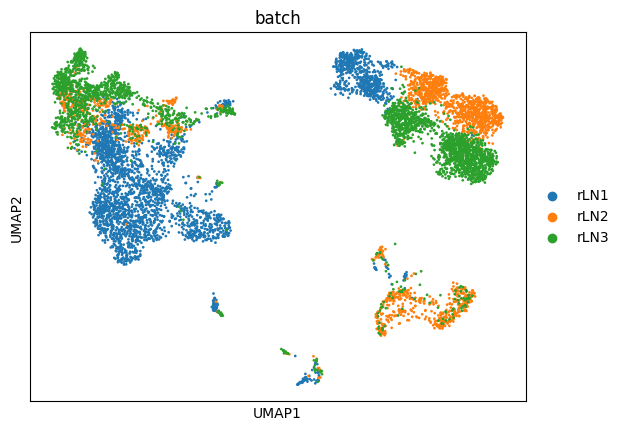

In [13]:
# see the batch effect
sc.pl.umap(adata_raw,color=['batch'],legend_fontsize=10)

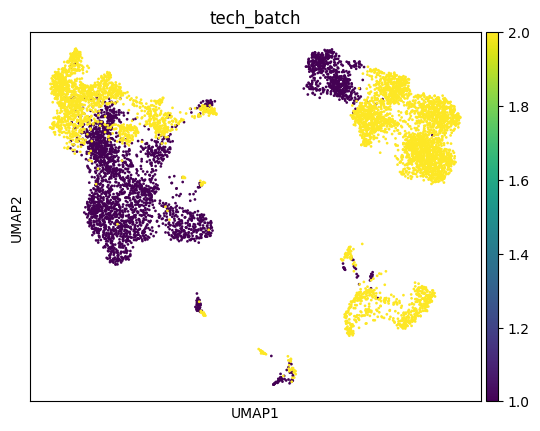

In [14]:
# see the batch effect
sc.pl.umap(adata_raw,color=['tech_batch'],legend_fontsize=10)

In [15]:
adata_raw

AnnData object with n_obs × n_vars = 7882 × 1463
    obs: 'tech_batch', 'batch', 'n_genes'
    var: 'gene_ids', 'EnsemblId-rLN1', 'EnsemblId-rLN2', 'EnsemblId-rLN3', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Integrating data using scalex

In [24]:
adata_raw_2 = adata_FL['rLN1'].concatenate(adata_FL['rLN2'], adata_FL['rLN3'], batch_categories=['rLN1', 'rLN2', 'rLN3'])

In [25]:
adata_raw_2.obs

,tech_batch,batch
barcode,,
AAACCTGCAAGGCTCC-1-rLN1,1,rLN1
AAACCTGCAGGTCGTC-1-rLN1,1,rLN1
AAACCTGGTTCCACTC-1-rLN1,1,rLN1
AAACCTGTCTGATACG-1-rLN1,1,rLN1
AAACGGGAGCGGCTTC-1-rLN1,1,rLN1
...,...,...
TTTGTCACACGGACAA-1-rLN3,2,rLN3
TTTGTCACACTTAACG-1-rLN3,2,rLN3
TTTGTCAGTGATAAGT-1-rLN3,2,rLN3


In [18]:
adata_ref=SCALEX(adata_raw_2,batch_name='tech_batch',min_features=600, min_cells=3, outdir='rLN_output/',show=False,gpu=7)

2024-02-02 15:43:21,364 - SCALEX - INFO - Raw dataset shape: (8063, 22164)
2024-02-02 15:43:21,367 - SCALEX - INFO - There are 2 batches under batch_name: tech_batch
2024-02-02 15:43:21,368 - SCALEX - INFO - Preprocessing
2024-02-02 15:43:21,400 - SCALEX - INFO - Filtering cells
2024-02-02 15:43:21,797 - SCALEX - INFO - Filtering features
2024-02-02 15:43:22,013 - SCALEX - INFO - Normalizing total per cell
2024-02-02 15:43:22,091 - SCALEX - INFO - Log1p transforming
2024-02-02 15:43:22,232 - SCALEX - INFO - Finding variable features
2024-02-02 15:43:23,377 - SCALEX - INFO - Batch specific maxabs scaling
2024-02-02 15:43:32,583 - SCALEX - INFO - Processed dataset shape: (7880, 15990)
Epochs: 100%|██████████| 244/244 [5:09:56<00:00, 76.21s/it, recon_loss=2159.730,kl_loss=7.441]     
2024-02-02 20:53:42,997 - SCALEX - INFO - Plot umap


In [19]:
sc.settings.set_figure_params(dpi=80, facecolor='white',figsize=(3,3),frameon=True)

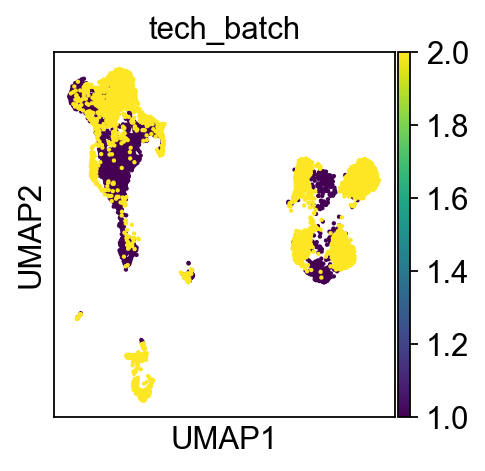

In [20]:
sc.pl.umap(adata_ref,color=['tech_batch'],legend_fontsize=10)

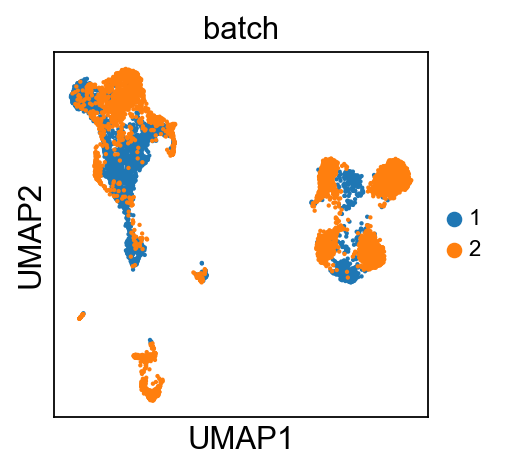

In [21]:
sc.pl.umap(adata_ref,color=['batch'],legend_fontsize=10)